In [1]:
import sys
sys.path.append('/home/ottok92/Dev/elogroup2/')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.eda import BCW_Explorer
from sklearn import preprocessing

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})

In [2]:
eda = BCW_Explorer()

# 1. Data Quality

In [3]:
eda.data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
(mean, radius)                     569 non-null float64
(mean, texture)                    569 non-null float64
(mean, perimeter)                  569 non-null float64
(mean, area)                       569 non-null float64
(mean, smoothness)                 569 non-null float64
(mean, compactness)                569 non-null float64
(mean, concavity_intensity)        569 non-null float64
(mean, concavity_count)            569 non-null float64
(mean, symmetry)                   569 non-null float64
(mean, fractal_dimension)          569 non-null float64
(std, radius)                      569 non-null float64
(std, texture)                     569 non-null float64
(std, perimeter)                   569 non-null float64
(std, area)                        569 non-null float64
(std, smoothness)                  569 non-null float64
(std, compactness)                 569 non-null float64

# 2. Data Analysis

## 2.1 Overview of Variables

In [4]:
print(
    'Attributes:\n\t{0}\n'.format(
        ', '.join(str(x) for x in eda.data.columns.get_level_values('attributes').unique() if x)
    ),
    '\n... where each attribute is summarized by:\n\t{0}'.format(
        ', '.join(str(x) for x in eda.data.columns.get_level_values('summaries').unique() if x != 'label')
    ),
    '\n\n... for a total of 30 features'
)


Attributes:
	radius, texture, perimeter, area, smoothness, compactness, concavity_intensity, concavity_count, symmetry, fractal_dimension
 
... where each attribute is summarized by:
	mean, std, meanmax3 

... for a total of 30 features


---
At first, we should assume that there is correlation between some of the features given the nature of the attributes which they summarize.
* radius yields (although the attribute is the mean of distances from center to points on the perimeter)
    * perimiter, area, smoothness (local variation in radius lengths) and compactness (perimeter^2 / area - 1.0);

We explore whether they significantly correlate in the section 2.3
<br />

\> **What is the attribute Fractal Dimension?**<br />
&emsp;Fractal dimension is a measure of how regular the contour of a shape is.<br />
It is approximated by measuring the downward slope of the log of observed perimeter plotted agains the log of a "ruler" size.<br />
Hence, a higher value corresponds to a less regular contour, which in turn means a higher probability of malignancy (Wolberg et al. 1994)


## 2.2 Research Questions (RQs)

1. What are the most significant features, and how to measure significance?
2. Which classifiers are most suitable for the task, and how to decide?
3. What performance measure should be favored during hyperparameter tuning?
4. How much better (or worse) are classifiers induced from reduced dimensionality?

## 2.3 Class Imbalance, Feature Distribution and Selection

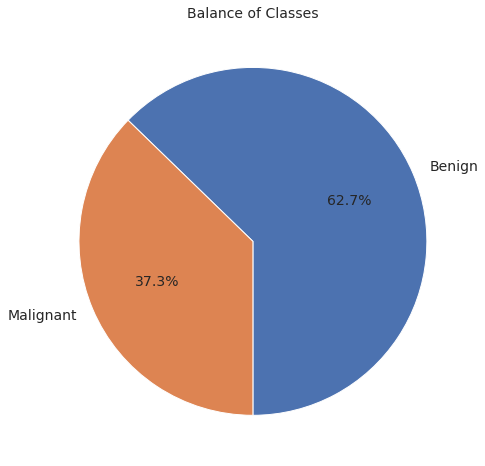

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_title('Balance of Classes', fontsize=14)

eda.data['label']\
    .map({1: 'Malignant', 0: 'Benign'})\
    .value_counts()\
    .plot(
        ax=ax,
        kind='pie',
        autopct='%1.1f%%',
        startangle=270,
        fontsize=14,
        label=''
    )

plt.show()

### - Imbalanced Classes
&emsp;There are almost twice as many benign observations than malignant, which can become an issue while inducing machine learning models. We can either employ a sampling technique or adjust our assessment of models to account for such imbalance. The former entails taking advantage of techniques such as SMOTE to generate new samples that follow the distribution of a give class, the latter means going beyond accuracy measures and throroughly assessing the assumptions and aims of other methods such as Confusion Matrix and Reliability Diagrams.<br />
<br />

<!-- <center><img style="margin-bottom:5mm" src="https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/resampling.png"><center/>
<center>Figure 1. Approaches to resampling<center/>
<center style="margin-bottom:5mm">Source. https://tinyurl.com/yy2qtbe2<center/>
 -->

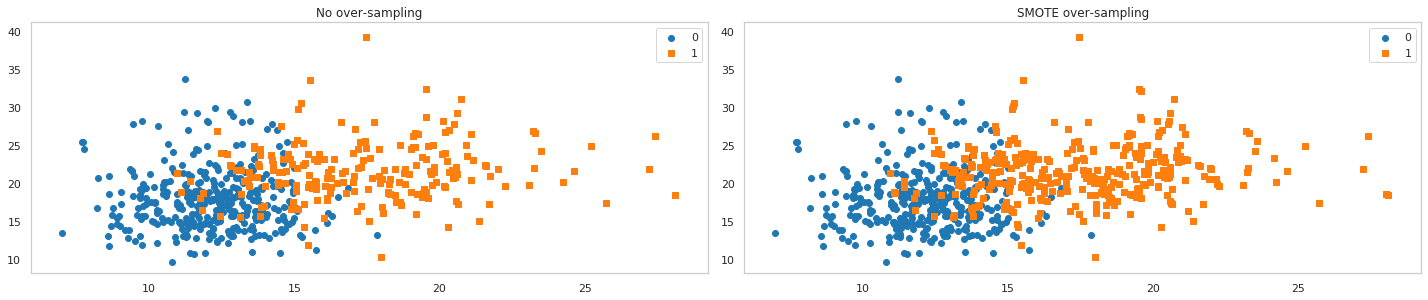

In [6]:
from imblearn.over_sampling import SMOTE

def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    
X = eda.data.drop(('label', ''), axis=1).values
y = eda.data.droplevel(1, axis=1)['label'].values

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_sample(X, y)

f = plt.figure(figsize=(20,8))

plt.subplot(2, 2, 1)
plot_2d_space(X, y, 'No over-sampling')

plt.subplot(2, 2, 2)
plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling')

plt.tight_layout()


plt.show()

del X, y, X_sm, y_sm

> For now, we choose to employ better assessment methods so as to avoid injecting bias into the dataset due to the delicate nature of this study.

&emsp;Before proceeding to the classifier induction task, we investigate the distribution of our features, comprised of some **statistical analysis** and **data visualization**, and whether there are any redundant candidates for removal via **correlation clustering**.<p/>

### - Feature Distribution

In [7]:
from scipy.stats import boxcox, skew

def plot_compare_classdistribution(in_df: pd.DataFrame, summary=None, ax=None, feats=None):
    '''
    '''
    try:
        df = in_df[feats].apply(preprocessing.scale, axis=0).copy()
    
    except KeyError:
        df = in_df.apply(preprocessing.scale, axis=0).copy()

    try:
        data = df.xs(summary, level='summaries', axis=1)
    
    except KeyError:
        data = df

    # melts columns' (name, value) pair into two columns
    df =\
        pd.melt(
            pd.concat(
                [
                    eda.data.droplevel(1, axis=1)['label'],
                    data
                ],
                axis=1
            ),
            id_vars='label',
            var_name='features',
            value_name='value'
        )

    # plots comparative distribution of classes for each 'mean' feature
    return\
        sns.violinplot(
            ax=ax,
            data=df,
            y="value",
            x="features",
            hue="label",
            inner="quartile",
            split=True,
        )


def transform_skew(df: pd.DataFrame) -> pd.DataFrame:
    '''
    Transforms data with Boxcox transformation
    Keeps the transformation only if it is less skewed than the original
    '''
    skew_transformed = pd.DataFrame()

    for feat in df.drop('label', axis=1):

        data = df.drop('label', axis=1)[feat].values
        posdata = data[data > 0]
        # posdata = eda.data[eda.data[feat]>0][feat]

        x, lmbda = boxcox(posdata, lmbda=None)
        
        transform = np.empty_like(data)
        transform[data > 0] = x
        transform[data == 0] = -1/lmbda

        if abs(skew(transform)) < abs(skew(data)):
            skew_transformed[feat] = transform

        else:
            skew_transformed[feat] = data
    
    skew_transformed.columns =\
        pd.MultiIndex.from_tuples(
            list(skew_transformed.columns),
            names=('summaries', 'attributes')
        )

    return skew_transformed

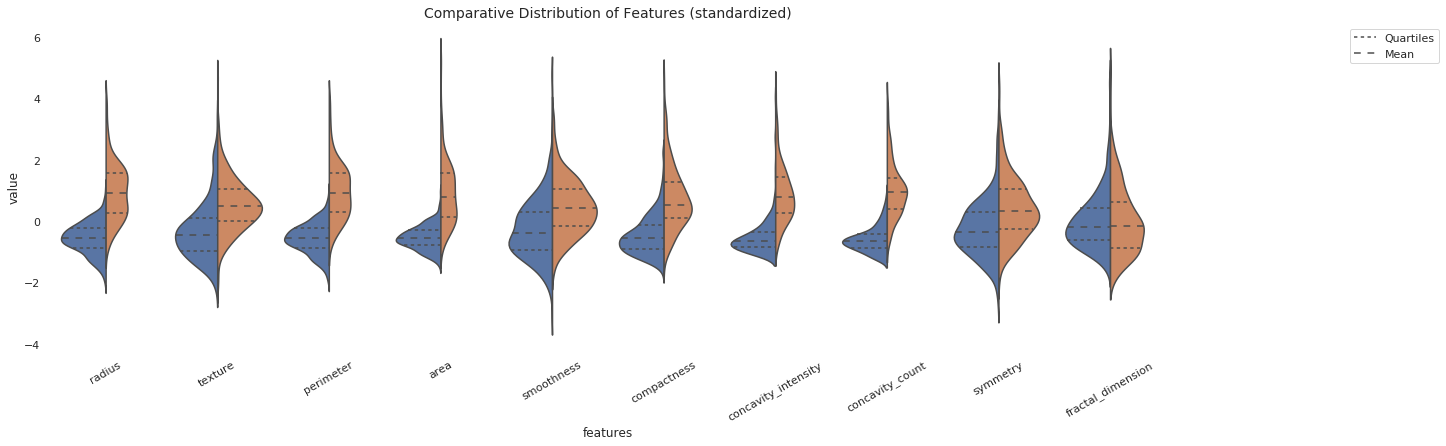

In [8]:
# -------------------------------------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

ax.set_title('Comparative Distribution of Features (standardized)', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plot_compare_classdistribution(eda.data, ax=ax, summary='mean')

ax.tick_params(axis='x', labelrotation=30)
ax.legend_.remove()
leg = ax.legend(['Quartiles', 'Mean'], loc='upper right', bbox_to_anchor=(1.25, 1))

plt.show()

In [9]:
print('Skewness of features:')
eda.data.skew().sort_values(ascending=False).sort_index(level='summaries', sort_remaining=False)

Skewness of features:


summaries  attributes         
mean       area                   1.645732
           concavity_intensity    1.401180
           fractal_dimension      1.304489
           compactness            1.190123
           concavity_count        1.171180
           perimeter              0.990650
           radius                 0.942380
           symmetry               0.725609
           texture                0.650450
           smoothness             0.456324
std        area                   5.447186
           concavity_intensity    5.110463
           fractal_dimension      3.923969
           perimeter              3.443615
           radius                 3.088612
           smoothness             2.314450
           symmetry               2.195133
           compactness            1.902221
           texture                1.646444
           concavity_count        1.444678
meanmax3   area                   1.859373
           fractal_dimension      1.662579
           compactness 

In [10]:
print('Applies boxcox transformation')
transformed = transform_skew(eda.data)
transformed['label'] = eda.data['label']

Applies boxcox transformation


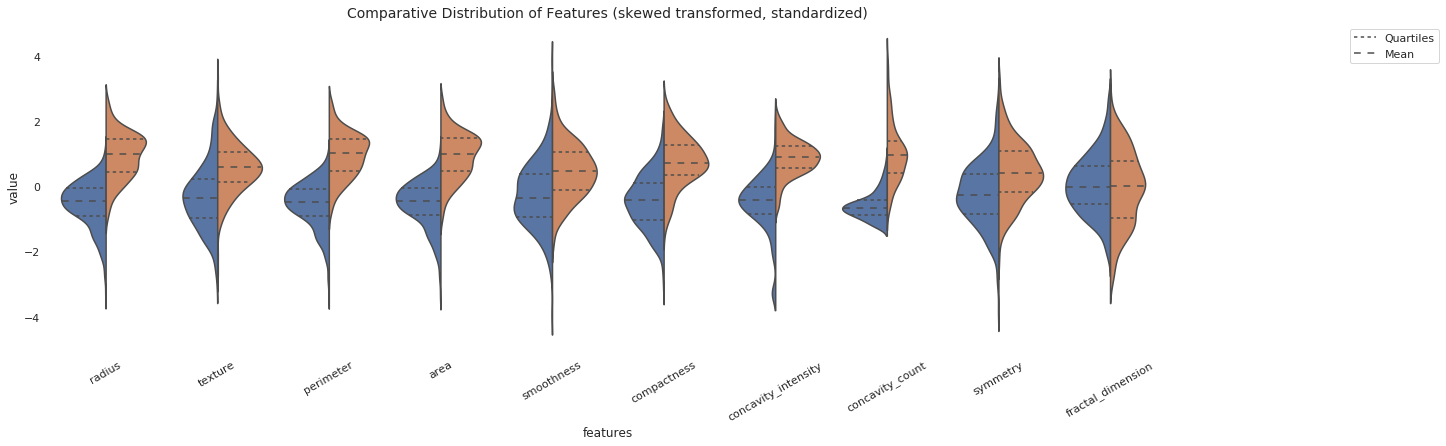

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(20, 6))

ax.set_title('Comparative Distribution of Features (skewed transformed, standardized)', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plot_compare_classdistribution(transformed, summary='mean')

ax.tick_params(axis='x', labelrotation=30)
ax.legend_.remove()
ax.legend(['Quartiles', 'Mean'], loc='upper right', bbox_to_anchor=(1.25, 1))

plt.show()

In [12]:
print('Skewness after Boxcox transform:')
transformed.skew().sort_values(ascending=False).sort_index(level='summaries', sort_remaining=False)

Skewness after Boxcox transform:


summaries  attributes         
mean       concavity_count        1.171180
           fractal_dimension      0.013525
           perimeter              0.006916
           radius                 0.006255
           area                   0.005090
           smoothness             0.002393
           texture               -0.000115
           compactness           -0.001664
           symmetry              -0.007120
           concavity_intensity   -0.654761
meanmax3   concavity_count        0.492616
           perimeter              0.030437
           radius                 0.029596
           area                   0.026589
           fractal_dimension      0.024883
           smoothness             0.001099
           texture               -0.005091
           compactness           -0.005668
           symmetry              -0.031618
           concavity_intensity   -0.371431
std        concavity_count        1.444678
           area                   0.058529
           perimeter   

### - Correlation Analysis

In [13]:
def get_unique_correlation(data: pd.DataFrame, threshold=0.5) -> pd.DataFrame:
    try:
        tmp = data.drop('label', axis=1).copy()
    
    except KeyError:
        pass

    tmp.columns = tmp.columns.to_flat_index()
    dataCorr = tmp.corr(method='pearson')

    dataCorr = dataCorr.mask(np.tril(np.ones(dataCorr.shape)).astype(np.bool))
    dataCorr = dataCorr[abs(dataCorr) >= threshold].stack()

    dataCorr = dataCorr.reset_index(level=0)
    dataCorr.index = pd.MultiIndex.from_tuples(dataCorr.index, names=('summaries', 'attributes'))
    
    return dataCorr.sort_index(level='attributes').sort_index(level='summaries', sort_remaining=False)

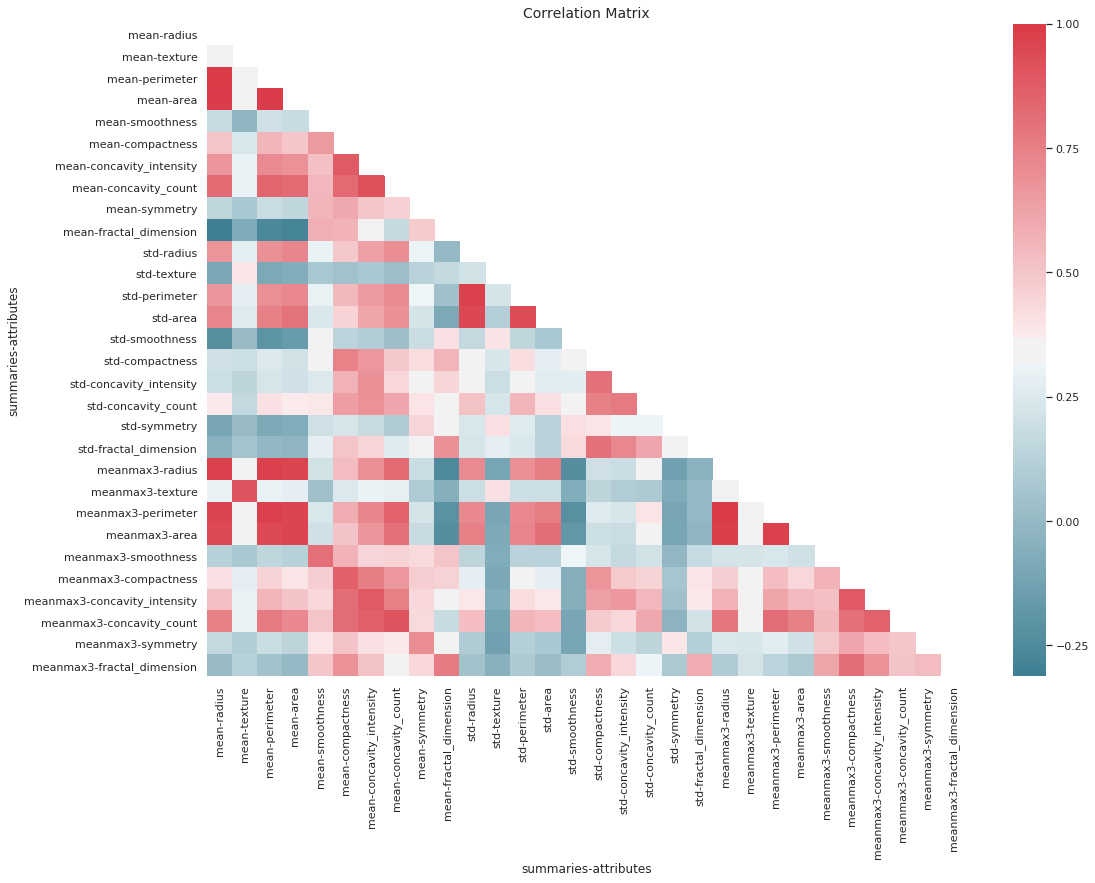

In [14]:
# -------------------------------------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(17, 12))
ax.set_title('Correlation Matrix', fontsize=14)

corr = eda.data.drop('label', axis=1).corr()

# generates an upper diagonal mask
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(
    corr,
    ax=ax,
    vmax=1,
    cmap=cmap,
    mask=mask,
    annot=False,
    square=False,
)

plt.show()

**Feature Selection Stategy**<br />
&emsp;Before applying an automated search for the optimal dimensionality for each classifer, we investigate features we consider relevant for the sake of comparison. There are a few features (variables) that correlate with many others, which could lead to using them to represent all others. At the end of this process, we will be able to answer **RQ1**.
* What are the most significant features, and how to measure significance? (RQ1)

**Correlation clustering** is the task of ...

In [15]:
def correlation_clustering(corr: np.ndarray, labels: np.ndarray, threshold=0.5, ax=plt.axes, maxclust=None) -> (dict or np.ndarray):
    '''
    '''
    dissimilarity = 1 - np.abs(corr)
    hierarchy = linkage(squareform(dissimilarity), method='ward', metric='distance')
    
    return\
        (
            fcluster(hierarchy, maxclust, criterion='maxclust') if maxclust
            else
            dendrogram(
                hierarchy, color_threshold=None,
                labels=labels, ax=ax,
                distance_sort='ascending',
                leaf_font_size=12,
                orientation='right',
            )
        )
        

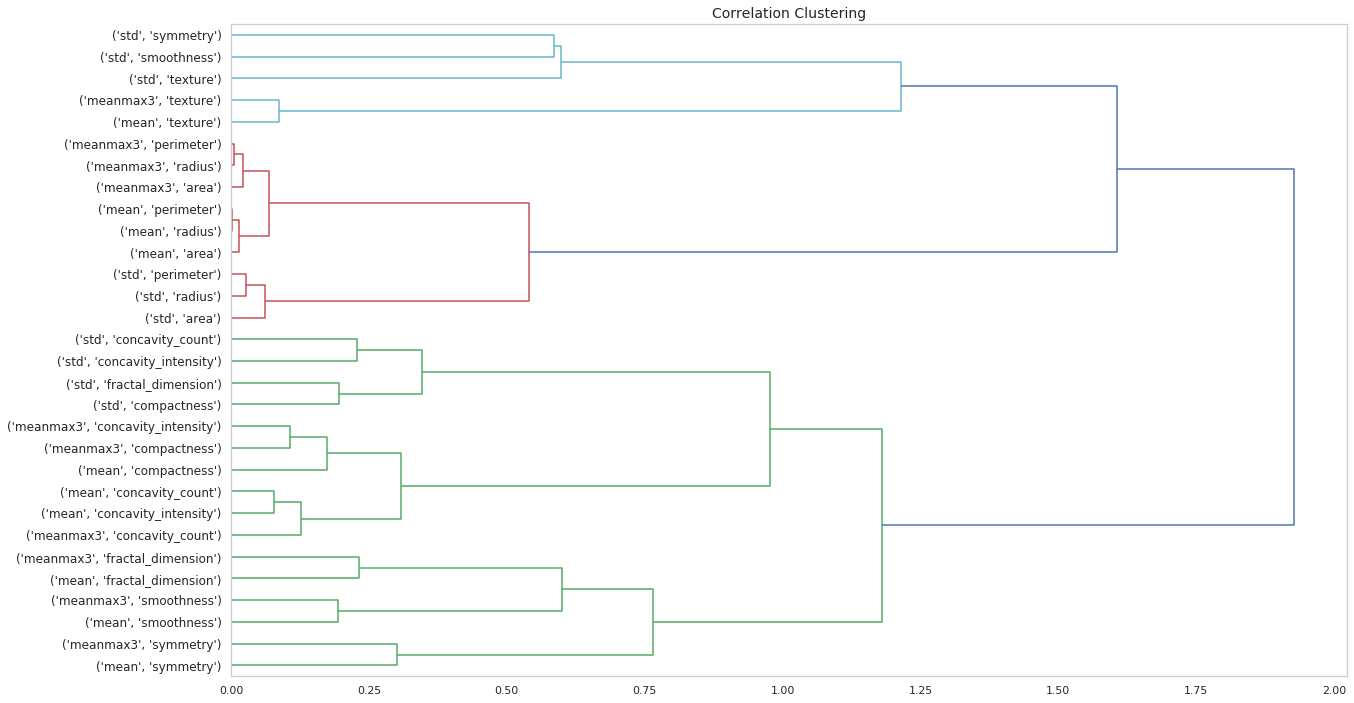

In [16]:
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

fig, ax = plt.subplots(1, 1, figsize=(20, 12))
ax.set_title('Correlation Clustering', fontsize=14)

d = correlation_clustering(corr.values, corr.index.values, ax=ax)

# plt.xticks(rotation=90)
plt.show()


In [17]:
# groups features into their respective clusters
cluster = correlation_clustering(corr.values, corr.index.values, maxclust=3)
cluster =\
    pd.Series(cluster, corr.index.values, name='cluster')\
        .reset_index().groupby('cluster')['index'].apply(np.array)\
        .to_dict()

In [ ]:
import plotly.graph_objects as go
from IPython.display import display
from plotly.subplots import make_subplots
from ipywidgets import interact, interact_manual

@interact
def viz_cluster_separation(
    feature1=[pair[0] +'_'+ pair[1] for pair in cluster[1]],
    feature2=[pair[0] +'_'+ pair[1] for pair in cluster[2]],
    feature3=[pair[0] +'_'+ pair[1] for pair in cluster[3]]
):
    '''
    '''
    labels = eda.data[('label', '')]
    feature1 = tuple(feature1.split('_', 1))
    feature2 = tuple(feature2.split('_', 1))
    feature3 = tuple(feature3.split('_', 1))

    fig =\
        make_subplots(
            rows=1, cols=2,
            specs=[
                [{'is_3d': True}, {'is_3d': True}]
            ],
            print_grid=False,
            subplot_titles=('Original features', 'Standardized features')
        )

    x = eda.data[feature1]
    y = eda.data[feature2]
    z = eda.data[feature3]

    fig.add_trace(
        go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='markers',
            showlegend=False,
            
            marker=dict(
                size=6,
                color=labels,
                colorscale=['#CC8963', '#5875A4'],
                opacity=1.0
            )
        ),
        row=1, col=1
    )

    x = transformed[feature1]
    y = transformed[feature2]
    z = transformed[feature3]

    fig.add_trace(
        go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='markers',
            showlegend=False,
            marker=dict(
                size=6,
                color=labels,
                colorscale=['#CC8963', '#5875A4'],
                opacity=1.0
            )
        ),
        row=1, col=2
    )

    fig.update_layout(
        width=1200,
        height=600,
        margin=dict(r=10, l=10, b=10, t=10),
        title_text='Class separation',
        scene = dict(
            xaxis_title='Mean Texture',
            yaxis_title='Worst Area',
            zaxis_title='Worst Smoothness'
        )
    )

    fig.show()


interactive(children=(Dropdown(description='feature1', options=('mean_smoothness', 'mean_compactness', 'mean_c…

What are the most significant features, and how to measure significance? **(RQ1)**
* Selects the feature that has highest correlation to target variable ('label') within each cluster.

In [ ]:
target = eda.data.corr()[('label', '')]
selected_feats = [target[cluster[k]].idxmax() for k in cluster.keys()]
selected_feats

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# ax[0].set_title('Distribution of selected features (standardized)', fontsize=14)
# ax[0].spines['top'].set_visible(False)
# ax[0].spines['bottom'].set_visible(False)
# ax[0].spines['right'].set_visible(False)
# ax[0].spines['left'].set_visible(False)

# plot_compare_classdistribution(eda.data, ax=ax[0], feats=selected_feats)

# ax[0].tick_params(axis='x', labelrotation=30)
# ax[0].legend_.remove()
# leg = ax[0].legend(['Quartiles', 'Mean'], loc='upper right', bbox_to_anchor=(1.25, 1))

ax.set_title('Distribution of selected features (skewed tranformed and standardized)', fontsize=14)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plot_compare_classdistribution(transformed, ax=ax, feats=selected_feats)

ax.tick_params(axis='x', labelrotation=30)
ax.legend_.remove()
leg = ax.legend(['Quartiles', 'Mean'], loc='upper right', bbox_to_anchor=(1.25, 1))

plt.show()

# 3. Classification

In [ ]:
from sklearn.model_selection import train_test_split

# splits data and labels
X = eda.data[selected_feats].values
y = eda.data.droplevel(1, axis=1)['label'].values

Xstd = transformed[selected_feats].values
ystd = transformed.droplevel(1, axis=1)['label'].values

# splits train and test
X_train, X_test, y_train, y_test =\
    train_test_split(
        X,
        y,
        test_size=.2,
        random_state=42
    )

Xstd_train, Xstd_test, ystd_train, ystd_test =\
    train_test_split(
        Xstd,
        ystd,
        test_size=.2,
        random_state=42
    )

## 3.1 Model Selection and Induction
Which classifiers are most suitable for the task, and how to decide? **(RQ2)**

When choosing a solution to a problem, one must keep in mind the principle of Occam's Razor, which states that given two equally effective solutions, the simpler one is more likely to be the correct one. ~~Thus, having visually observed that our selected features nearly separate the classes linearly, we choose linear models for classification. However we must also test this assumption (classes are linearly separable) so that we have more confidence in our classification. We test our assumption by training linear kernel Support Vector Machine Classifier. If such classifier achieves perfect accuracy (100%), it means that our classes are linearly separable~~. Classes are not entirely linearly separable. Still, we keep the test in this document as evidence of it.

### - Test linear separability of classes

**-- Convex Hulls and Linear Programming**

In [ ]:
#Drawing Convex Hulls to test for intersection 
from scipy.spatial import ConvexHull
from sklearn.preprocessing import StandardScaler
from scipy.optimize import linprog

feats = [x[0]+'_'+x[1] for x in eda.data[selected_feats].columns.to_flat_index()]

@interact
def convex_hulls_separability(
    feature1=feats,
    feature2=feats[::-1]
):
    if feature1 != feature2:
        feats = [tuple(x.split('_', 1)) for x in [feature1, feature2]]
        data = eda.data[feats].copy()
        data.columns = data.columns.to_flat_index()
        data['label'] = ystd
        label = ystd

        plt.clf()
        plt.figure(figsize = (20, 6))
        names = ['Benign', 'Malignant']
        colors = ['#CC8963', '#5875A4']
        
        plt.title('{0} vs. {1}'.format(feature1.upper(), feature2.upper()))
        plt.xlabel(feature1)
        plt.ylabel(feature2)

        for i in range(len(names)):
            bucket = data[data['label'] == i]
            bucket = bucket.iloc[:,[0,1]].values
            hull = ConvexHull(bucket)
            plt.scatter(bucket[:, 0], bucket[:, 1], label=names[i]) 
            for j in hull.simplices:
                plt.plot(bucket[j,0], bucket[j,1], colors[i])

        plt.legend()
        plt.show()
        
        feats = [tuple(x.split('_', 1)) for x in [feature1, feature2]]
        data = eda.data[feats].copy()
        data.columns = data.columns.to_flat_index()
        data['label'] = ystd


        data["newlabel"] = np.where(data['label'] == 0, 1 , -1)

        sc = StandardScaler()
        tmp = data.iloc[:,[0,1]].values
        tmp = sc.fit_transform(tmp)

        xx = np.array(data['newlabel'].values.reshape(-1,1) * tmp)
        t = np.where(data['label'] == 0, 1 , -1)

        #2-D array which, when matrix-multiplied by x, gives the values of 
        #the upper-bound inequality constraints at x.
        A_ub = np.append(xx, t.reshape(-1,1), 1)

        #1-D array of values representing the upper-bound of each 
        #inequality constraint (row) in A_ub.
        b_ub = np.repeat(-1, A_ub.shape[0]).reshape(-1,1)

        # Coefficients of the linear objective function to be minimized.
        c_obj = np.repeat(1, A_ub.shape[1])
        res = linprog(c=c_obj, A_ub=A_ub, b_ub=b_ub,
                      options={"disp": False})

        if res.success:
            print('There is linear separability between Benign and Malignant via "{}" and "{}"'.format(feature1, feature2))
        else:
            print('No linear separability between Benign and Malignant via "{}" and "{}"'.format(feature1, feature2))
    
    else:
        print('Please, select two distinct features to draw hulls and check for separability')

In [ ]:
del feats

**-- Linear SVM**

In [ ]:
# from sklearn.svm import LinearSVC
from sklearn.metrics import balanced_accuracy_score

# clf =\
#     LinearSVC(
#         random_state=0,
#         tol=1e-3,
#         C=float('inf'),
#         fit_intercept=False,
# #         class_weight='balanced',
#         max_iter=1e8
#     )

# clf.fit(Xstd, ystd)
clf = pd.read_pickle('../data/models/clf_linear_separable_test.pkl')
y_pred = clf.predict(Xstd)

print('Accuracy balanced between both classes:')
balanced_accuracy_score(ystd, y_pred)

&emsp;Both tests show us that although nearly, the classes are not fully linearly separable. This informs our choice of classifiers, which will favor non-linear ones such as RBF SVM, MLP, Random Forest and so on. Next, we induce our models and define metrics for comparison between models and data dimensionality.

In [ ]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import SGDClassifier


class ClfSwitcher(BaseEstimator):
    '''
    Boilerplate class to support hyperparameter tunning for multiple classifiers
    '''
    def __init__(
        self, 
        estimator = SGDClassifier(),
    ): 
        self.estimator = estimator


    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


    def predict_proba(self, X):
        return self.estimator.predict_proba(X)


    def score(self, X, y):
        return self.estimator.score(X, y)

    def decision_function(self, X):
        return self.estimator.decision_function(X)


In [ ]:
# from sklearn import feature_selection
# from sklearn import preprocessing
# from sklearn.model_selection import StratifiedKFold
# from sklearn.ensemble import ExtraTreesRegressor
# from sklearn.pipeline import Pipeline
# import numpy as np
# import pandas as pd

# class PipelineRFE(Pipeline):

#     def fit(self, X, y=None, **fit_params):
#         super(PipelineRFE, self).fit(X, y, **fit_params)
#         self.feature_importances_ = self.steps[-1][-1].feature_importances_
#         return self

# pipe = PipelineRFE(
#     [
#         ('std_scaler', preprocessing.StandardScaler()),
#         ("ET", ExtraTreesRegressor(random_state=42, n_estimators=250, shuffle=True))
#     ]
# )

# # Sets RNG seed to reproduce results (your results should match mine)
# _ = StratifiedKFold(random_state=42)

# feature_selector_cv = feature_selection.RFECV(pipe, cv=10, step=1, scoring="neg_mean_squared_error")
# feature_selector_cv.fit(X_train, y_train)
# eda.data.drop(('label', ''), axis=1).columns.to_flat_index()[feature_selector_cv.support_].tolist()

## 3.2 Assessing Results
What performance measure should be favored during hyperparameter tuning? **(RQ3)**

How much better (or worse) are classifiers induced from reduced dimensionality? **(RQ4)**

### - Confusion Matrix

### - Reliability Diagrams

### - Precision Recall Curve

## 3.4 Conclusion and Future Work